## FINAL MODEL 

Polaczenie LightBgm z Catboost za pomoca soft VoteClassifiera

In [5]:
from ColumnTransformers import *
from AdvModels import *

In [6]:

class CatBoostWithCatFeatures(CatBoostClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cat_features_indices = None
    
    def fit(self, X, y=None, **fit_params):
        X_mod=self._preprocess(X)
        X_mod[:, self.cat_features_indices] = X_mod[:, self.cat_features_indices].astype(str)
        
        super().fit(X_mod, y, cat_features=self.cat_features_indices, **fit_params)
        return self

    def _preprocess(self, X):
        if self.cat_features_indices is None:
            self.cat_features_indices = GetCategorical(X)
        X_mod = X.copy()
        X_mod[:, self.cat_features_indices] = X_mod[:, self.cat_features_indices].astype(str)
        return X_mod

    def predict(self, X, **kwargs):
        X_mod = self._preprocess(X)
        return super().predict(X_mod, **kwargs)

    def predict_proba(self, X, **kwargs):
        X_mod = self._preprocess(X)
        return super().predict_proba(X_mod, **kwargs)
  
def CatBoostPipeline(X):
    catboost_pipeline = Pipeline([
    ("preprocessor", CatBoostTransformer(
        Numerical=['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity']
        )),
    ("classifier", CatBoostWithCatFeatures(
        grow_policy="SymmetricTree",
        rsm=0.8,
        depth=9,
        auto_class_weights="Balanced",
        learning_rate=0.01,
        l2_leaf_reg=2,
        iterations=1500,
        border_count=256,
        verbose=0 ))])
    return catboost_pipeline

def LGBMClassifierPipeline(): 
    model=LGBMClassifier(
        colsample_bytree=0.8,
        is_unbalance=True,
        learning_rate=0.01,
        max_depth=2,
        min_split_gain=0.1,
        n_estimators=600,
        reg_lambda=1,
        subsample=1,
        verbosity=-1
    )
    result=PipelineModel(model)
    return result

def create_voting_classifier(X):
    
    catboost_pipeline = CatBoostPipeline(X)
    lgbm_pipeline = LGBMClassifierPipeline() 
    print(type(lgbm_pipeline))
    voting_ensemble = VotingClassifier(
        estimators=[
            ('catboost', catboost_pipeline),
            ('lgbm',     lgbm_pipeline)
        ],
        voting='soft'
    )
    return voting_ensemble

In [7]:
def FinalModel(X_train,X_test,y_train,y_test,threshold=0.5): 
    finalModel=create_voting_classifier(X_train)
    set_config(display='diagram')
    display(finalModel)
    finalModel.fit(X_train,y_train)
    y_scores=finalModel.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)
    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}")
    return finalModel

<class 'sklearn.pipeline.Pipeline'>


VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('time_features',
                                                                                TimeTransformer(is_catboost=True),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age'...
                                                                                 'source'])])),
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=30)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


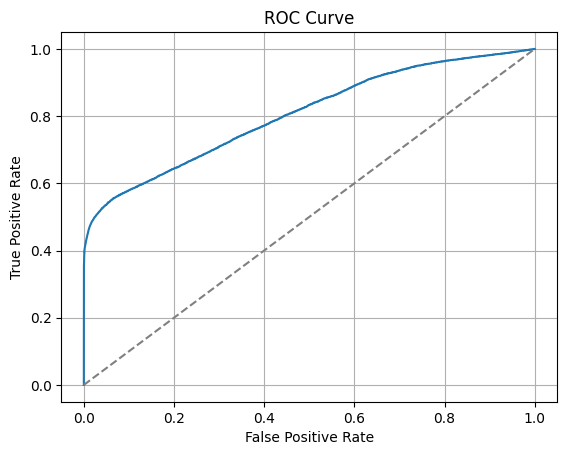

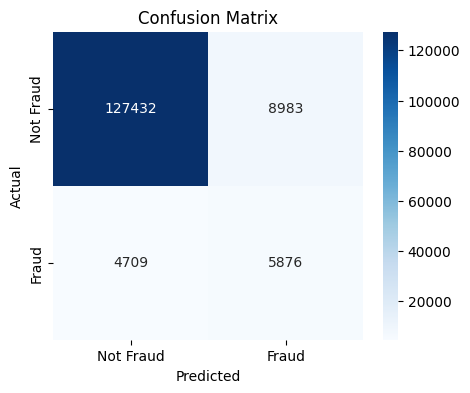

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95    136415
           1       0.40      0.56      0.46     10585

    accuracy                           0.91    147000
   macro avg       0.68      0.74      0.71    147000
weighted avg       0.92      0.91      0.91    147000

AUC: 0.8047327732030571


In [8]:
X_train,y_train=getTestData()
X_test,y_test=getTrainingData()
Model=FinalModel(X_train,X_test,y_train,y_test)